### **Importing Libraries**

In [ ]:
import os
import cv2
import random
import zipfile
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/GC10.zip', 'r')
zip_ref.extractall('/content/GC10')
zip_ref.close()

### Label Mapping

In [ ]:
xml_to_label_mapping = {
    '6_siban': 'silk_spot',
    '5_youban': 'oil_spot',
    '1_chongkong': 'punching_hole',
    '2_hanfeng': 'welding_line',
    '8_yahen': 'rolled_pit',
    '7_yiwu': 'inclusion',
    '4_shuiban': 'water_spot',
    '3_yueyawan': 'crescent_gap',
    '10_yaozhed': 'waist_folding',
    '10_yaozhe': 'waist_folding',
    '9_zhehen': 'crease',
    'd': 'welding_line'
}

In [ ]:
label_to_int_mapping = {
    'punching_hole': 0,
    'welding_line': 1,
    'crescent_gap': 2,
    'water_spot': 3,
    'oil_spot': 4,
    'silk_spot': 5,
    'inclusion': 6,
    'rolled_pit': 7,
    'crease': 8,
    'waist_folding': 9
}

### Reading Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/GC10_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2306 non-null   int64 
 1   image_path    2306 non-null   object
 2   label         2306 non-null   int64 
 3   mapped_label  2306 non-null   object
 4   Filename      2306 non-null   object
 5   xml_filename  2306 non-null   object
dtypes: int64(2), object(4)
memory usage: 108.2+ KB


In [ ]:
df.head()

,Unnamed: 0,image_path,label,mapped_label,Filename,xml_filename
0,0,/content/GC10/6/img_03_436152900_00535.jpg,6,silk_spot,img_03_436152900_00535.jpg,img_03_436152900_00535.xml
1,1,/content/GC10/6/img_06_4406645900_00501.jpg,6,silk_spot,img_06_4406645900_00501.jpg,img_06_4406645900_00501.xml
2,2,/content/GC10/6/img_02_4406645900_00346.jpg,6,silk_spot,img_02_4406645900_00346.jpg,img_02_4406645900_00346.xml
3,3,/content/GC10/6/img_06_4406645900_00490.jpg,6,silk_spot,img_06_4406645900_00490.jpg,img_06_4406645900_00490.xml
4,4,/content/GC10/6/img_01_425005700_00301.jpg,6,silk_spot,img_01_425005700_00301.jpg,img_01_425005700_00301.xml


### Convert XML Format to YOLO Format

In [ ]:
def convert_xml_to_yolo(xml_file, output_path, image_width, image_height):
  """Converts Pascal VOC XML annotations to YOLO format.

  Args:
    xml_file: Path to the XML annotation file.
    output_path: Path to save the YOLO annotation file.
    image_width: Width of the image.
    image_height: Height of the image.
  """
  tree = ET.parse(xml_file)
  root = tree.getroot()

  yolo_annotations = []
  for obj in root.findall('object'):
    label = obj.find('name').text
    if label in xml_to_label_mapping:
      label = xml_to_label_mapping[label]
    if label in label_to_int_mapping:
      label = str(label_to_int_mapping[label])
    else:
      print(f"Warning: Label '{label}' not found in mapping.")
      continue

    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)

    x_center = ((xmin + xmax) / 2) / image_width
    y_center = ((ymin + ymax) / 2) / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height

    yolo_annotations.append(f"{label} {x_center} {y_center} {width} {height}")

  with open(output_path, 'w') as f:
    for annotation in yolo_annotations:
      f.write(annotation + '\n')


def process_annotations(df, data_dir):
    """Processes annotations and creates YOLO format files.

    Args:
      df: Pandas DataFrame containing image information.
      data_dir: Path to directory containing images and XML files.
    """
    for index, row in df.iterrows():
        xml_filename = os.path.join('/content/GC10/lable',row['xml_filename'])
        if not os.path.exists('/content/GC10/yolo_labels'):
          os.makedirs('/content/GC10/yolo_labels')
        if os.path.exists(xml_filename):
            try:
                tree = ET.parse(xml_filename)
                root = tree.getroot()
                image_width = int(root.find('size').find('width').text)
                image_height = int(root.find('size').find('height').text)
                yolo_filename = os.path.join('/content/GC10/yolo_labels', row['Filename'].replace('.jpg', '.txt'))

                convert_xml_to_yolo(xml_filename, yolo_filename, image_width, image_height)
            except Exception as e:
                print(f"Error processing {xml_filename}: {e}")
        else:
            print(f"XML file not found for {xml_filename}")

process_annotations(df, '/content/GC10')

In [ ]:
## Save the YOLO Filename Format in Dataframe
df['yolo_filename'] = df['Filename'].apply(lambda x: x.replace('.jpg', '.txt'))

### Split Dataset

In [ ]:
### Train Test Split the entire Dataset
def split_train_test(df, train_ratio=0.8):
  """Splits the dataset into training and testing sets.

  Args:
    df: Pandas DataFrame containing image filenames and annotations.
    train_ratio: The proportion of the dataset to include in the training set.

  Returns:
    A tuple containing two DataFrames: train_df and test_df.
  """
  unique_images = df['Filename'].unique()
  random.shuffle(unique_images)
  train_size = int(len(unique_images) * train_ratio)
  train_images = unique_images[:train_size]
  test_images = unique_images[train_size:]

  train_df = df[df['Filename'].isin(train_images)]
  test_df = df[df['Filename'].isin(test_images)]

  return train_df, test_df

train_df, test_df = split_train_test(df)
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 1846
Testing set size: 460


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 1 to 2304
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     1846 non-null   int64 
 1   image_path     1846 non-null   object
 2   label          1846 non-null   int64 
 3   mapped_label   1846 non-null   object
 4   Filename       1846 non-null   object
 5   xml_filename   1846 non-null   object
 6   yolo_filename  1846 non-null   object
dtypes: int64(2), object(5)
memory usage: 115.4+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 2305
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     460 non-null    int64 
 1   image_path     460 non-null    object
 2   label          460 non-null    int64 
 3   mapped_label   460 non-null    object
 4   Filename       460 non-null    object
 5   xml_filename   460 non-null    object
 6   yolo_filename  460 non-null    object
dtypes: int64(2), object(5)
memory usage: 28.8+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2306 non-null   int64 
 1   image_path     2306 non-null   object
 2   label          2306 non-null   int64 
 3   mapped_label   2306 non-null   object
 4   Filename       2306 non-null   object
 5   xml_filename   2306 non-null   object
 6   yolo_filename  2306 non-null   object
dtypes: int64(2), object(5)
memory usage: 126.2+ KB


### Plot Images with YOLO Bounding Boxes

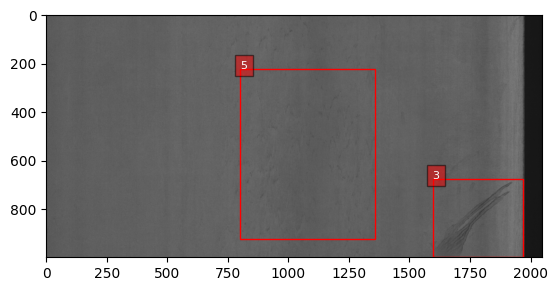

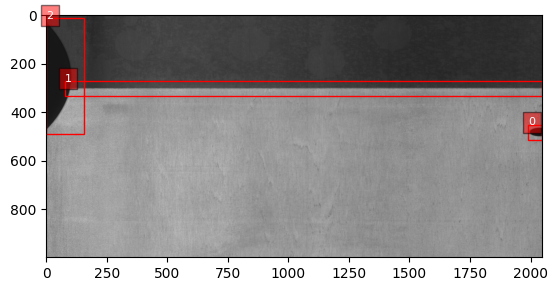

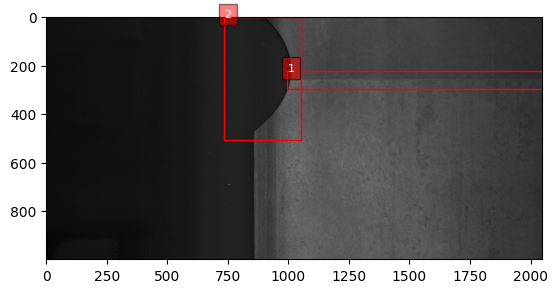

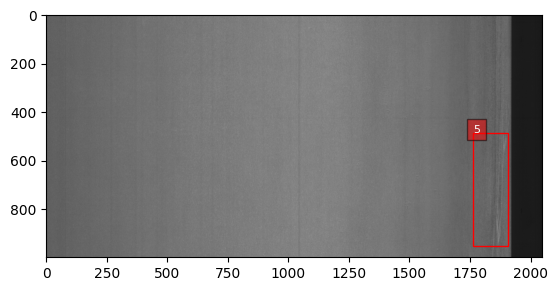

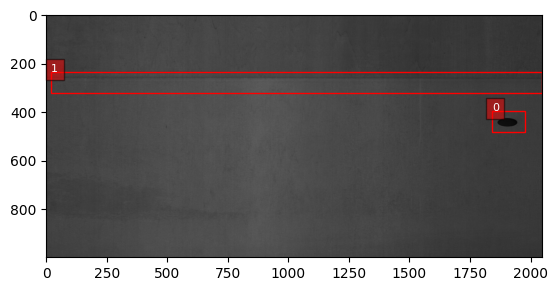

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_yolo_annotations(image_path, yolo_path):
  """Plots an image with YOLO annotations."""

  img = cv2.imread(image_path)
  fig, ax = plt.subplots(1)
  ax.imshow(img)

  with open(yolo_path, 'r') as f:
    for line in f:
      class_id, x_center, y_center, width, height = map(float, line.strip().split())

      img_width, img_height = img.shape[1], img.shape[0]
      x_min = int((x_center - width / 2) * img_width)
      y_min = int((y_center - height / 2) * img_height)
      x_max = int((x_center + width / 2) * img_width)
      y_max = int((y_center + height / 2) * img_height)

      rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x_min, y_min, str(int(class_id)), color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

  plt.show()

for index, row in train_df.sample(n=5).iterrows():  # Adjust the number of samples as needed
  image_path = os.path.join(row['image_path'])
  yolo_path = os.path.join('/content/GC10/yolo_labels', row['yolo_filename'])
  if os.path.exists(image_path) and os.path.exists(yolo_path):
    plot_image_with_yolo_annotations(image_path, yolo_path)


### Store the Images and Labels in YOLO Format

In [ ]:
import os
import shutil

def store_images_in_separate_folder(df, image_path_column, destination_folder):
    """Stores images from a DataFrame into separate folders.

    Args:
        df: Pandas DataFrame containing image information.
        image_path_column: The name of the DataFrame column containing image paths.
        destination_folder: Path to the directory where images will be stored.
    """

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for index, row in df.iterrows():
        image_path = row[image_path_column]
        if os.path.exists(image_path):
            filename = os.path.basename(image_path)
            destination_path = os.path.join(destination_folder, filename)

            shutil.copy(image_path, destination_path)
        else:
            print(f"Image not found at: {image_path}")

store_images_in_separate_folder(test_df, 'image_path', '/content/GC10/test/images')
store_images_in_separate_folder(train_df, 'image_path', '/content/GC10/train/images')

In [ ]:
def store_yolo_labels_in_separate_folder(df, yolo_filename_column, destination_folder):
    """Stores YOLO labels from a DataFrame into separate folders.

    Args:
        df: Pandas DataFrame containing YOLO label information.
        yolo_filename_column: The name of the DataFrame column containing YOLO label filenames.
        destination_folder: Path to the directory where YOLO labels will be stored.
    """

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for index, row in df.iterrows():
        yolo_filename = row[yolo_filename_column]
        yolo_path = os.path.join('/content/GC10/yolo_labels', yolo_filename)
        if os.path.exists(yolo_path):
            filename = os.path.basename(yolo_path)
            destination_path = os.path.join(destination_folder, filename)

            shutil.copy(yolo_path, destination_path)
        else:
            print(f"YOLO label not found at: {yolo_path}")


# Store YOLO labels for train and test sets in separate folders
store_yolo_labels_in_separate_folder(train_df, 'yolo_filename', '/content/GC10/train/labels')
store_yolo_labels_in_separate_folder(test_df, 'yolo_filename', '/content/GC10/test/labels')

### Store he Files and Labels for future reference

In [ ]:
def zip_folder(folder_path, zip_filename):
  """Zips a folder and its contents.

  Args:
    folder_path: Path to the folder to zip.
    zip_filename: Name of the zip file to create.
  """
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))


# Zip the train images and labels folders
zip_folder('/content/GC10/train', '/content/GC10/train.zip')
zip_folder('/content/GC10/test', '/content/GC10/test.zip')

In [ ]:
import zipfile

def extract_zip_folders(zip_file_path, extraction_path):
  """Extracts the contents of a zip file to a specified directory.

  Args:
    zip_file_path: The path to the zip file.
    extraction_path: The path to the directory where the contents will be extracted.
  """
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)
    print(f"Successfully extracted '{zip_file_path}' to '{extraction_path}'")
  except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'")
  except Exception as e:
    print(f"An error occurred while extracting the zip file: {e}")

train_zip_path = '/content/GC10/train.zip'
test_zip_path = '/content/GC10/test.zip'

extract_zip_folders(train_zip_path, '/content/train/')
extract_zip_folders(test_zip_path, '/content/test/')

Successfully extracted '/content/GC10/train.zip' to '/content/train/'
Successfully extracted '/content/GC10/test.zip' to '/content/test/'


### Load YOLO Model From Ultralytics

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install

# Define paths for your training data
train_images_path = '/content/train/images'
train_labels_path = '/content/train/labels'
val_images_path = '/content/test/images'
val_labels_path = '/content/test/labels'

# Create a YAML file for your dataset (e.g., data.yaml)
yaml_content = f"""
train: {train_images_path}
val: {val_images_path}

nc: 10  # Number of classes
names: ['punching_hole', 'welding_line', 'crescent_gap', 'water_spot', 'oil_spot', 'silk_spot', 'inclusion', 'rolled_pit', 'crease', 'waist_folding']
"""

with open('/content/yolov5/data.yaml', 'w') as f:
  f.write(yaml_content)

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 20.5 MB/s eta 0:00:00


### Train the YOLO Model

In [ ]:
# Train your YOLOv5 model
!python train.py --data /content/yolov5/data.yaml --weights yolov5s.pt --img 640 --batch 16 --epochs 20 --patience 3


# After training, you can find the best model weights in the 'runs/train/' directory.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-30 15:23:40.027711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 15:23:40.053972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 15:23:40.059911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

### Validate the model with trained Weights

In [ ]:
# validate the above trained model

!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/yolov5/data.yaml --img 640

val: data=/content/yolov5/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/test/labels.cache... 459 images, 0 backgrounds, 0 corrupt: 100% 459/459 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:15<00:00,  1.00s/it]
                   all        459        727      0.614      0.636      0.627      0.307
         punching_hole        459         63      0.889      0.984       0.98      0.579
          welding_line

### Detect the defects in test set

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --source /content/test/images --img 640 --conf 0.25 --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/459 /content/test/images/img_01_3402617700_00001.jpg: 320x640 1 crescent_gap, 27.7ms
image 2/459 /content/test/images/img_01_3437011300_00918.jpg: 320x640 1 water_spot, 7.4ms
image 3/459 /content/test/images/img_01_424799600_00002.jpg: 320x640 1 cre

### Save the trained model entire folder

In [ ]:
def zip_folder(folder_path, zip_filename):
  """Zips a folder and its contents.

  Args:
    folder_path: Path to the folder to zip.
    zip_filename: Name of the zip file to create.
  """
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Zip the 'yolov5/runs/train' folder
zip_folder('/content/yolov5', '/content/yolov5_trained_model.zip')

### Plot the Predicted Bounding Boxes for test set

img_08_425508200_00403.jpg
/content/yolov5/runs/detect/exp/img_08_425508200_00403.jpg


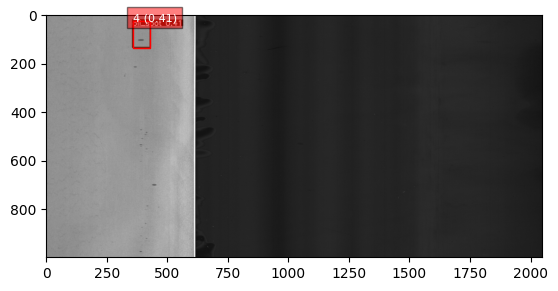

img_04_3402618000_00001.jpg
/content/yolov5/runs/detect/exp/img_04_3402618000_00001.jpg


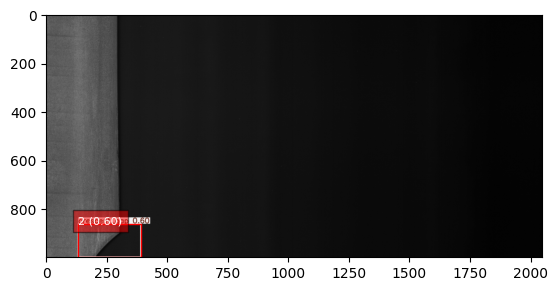

img_02_425507200_01510.jpg
/content/yolov5/runs/detect/exp/img_02_425507200_01510.jpg


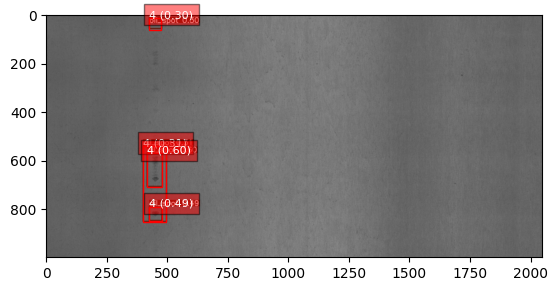

img_04_436163100_00021.jpg
/content/yolov5/runs/detect/exp/img_04_436163100_00021.jpg


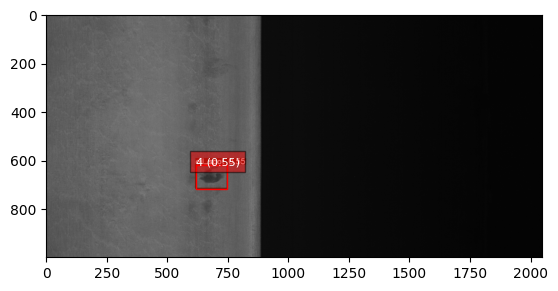

img_03_425501800_00018.jpg
/content/yolov5/runs/detect/exp/img_03_425501800_00018.jpg


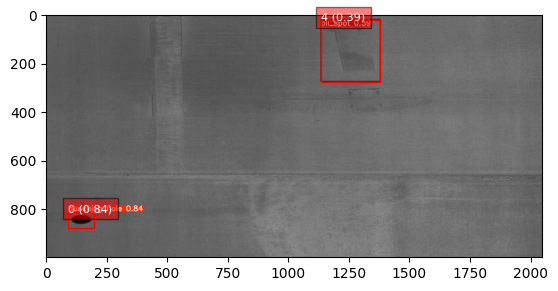

In [ ]:
def plot_predicted_boxes(image_path, label_path):
  """Plots an image with predicted bounding boxes from YOLO output."""
  img = cv2.imread(image_path)
  fig, ax = plt.subplots(1)
  ax.imshow(img)

  if os.path.exists(label_path):
    with open(label_path, 'r') as f:
      for line in f:
        class_id, x_center, y_center, width, height, confidence = map(float, line.strip().split())

        img_width, img_height = img.shape[1], img.shape[0]
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        x_max = int((x_center + width / 2) * img_width)
        y_max = int((y_center + height / 2) * img_height)

        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f"{int(class_id)} ({confidence:.2f})", color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

  plt.show()


# Get a list of image files in the test/images folder
test_images_folder = '/content/yolov5/runs/detect/exp'
test_labels_folder = '/content/yolov5/runs/detect/exp/labels'
test_image_files = [f for f in os.listdir(test_images_folder) if f.endswith(('.jpg', '.png'))]

# Iterate through a few sample images and plot predicted boxes
for image_file in test_image_files[:5]:  # Show predictions for 5 images
  print(image_file)
  image_path = os.path.join(test_images_folder, image_file)
  print(image_path)
  label_file = os.path.splitext(image_file)[0] + '.txt'
  label_path = os.path.join(test_labels_folder, label_file)

  if os.path.exists(image_path) and os.path.exists(label_path):
    plot_predicted_boxes(image_path, label_path)

### Plot the Actual Bounding Boxes for test set

img_08_425508200_00403.jpg


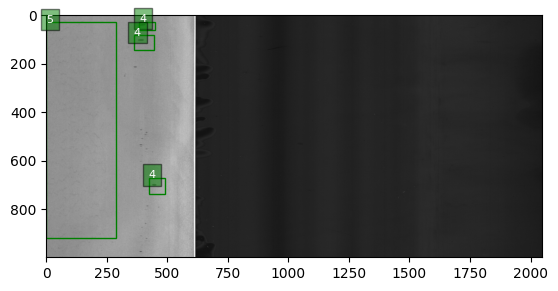

img_04_3402618000_00001.jpg


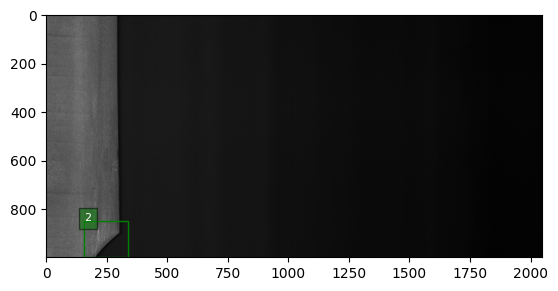

img_02_425507200_01510.jpg


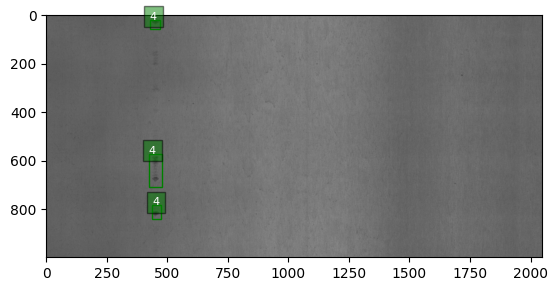

img_04_436163100_00021.jpg


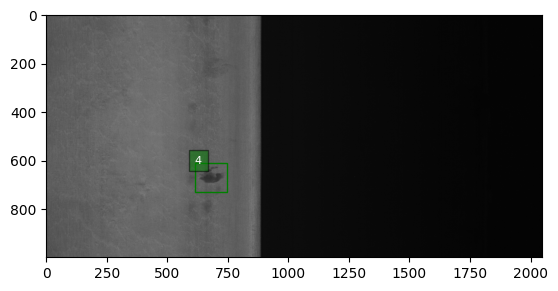

img_03_425501800_00018.jpg


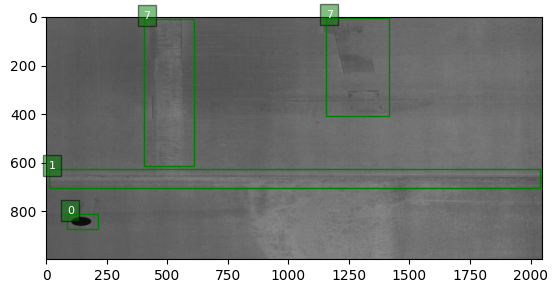

In [ ]:
# prompt: plot the actual bounding boxes for the same test samples of filename img_03_425638500_00716.jpg

def plot_actual_boxes(image_path, label_path):
    """Plots an image with actual bounding boxes from the original annotations."""
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())

                img_width, img_height = img.shape[1], img.shape[0]
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                x_max = int((x_center + width / 2) * img_width)
                y_max = int((y_center + height / 2) * img_height)

                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='g', facecolor='none') # Green for actual boxes
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{int(class_id)}", color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5)) # Green text for actual boxes

    plt.show()

# Example usage for a specific image (replace with your desired image)
#image_filename_list = ['img_03_425638500_00716.jpg','img_02_425638500_00001.jpg', 'img_01_424825700_00001.jpg', 'img_03_424714400_00306.jpg', 'img_06_425614600_00411.jpg']
for image_filename in test_image_files[:5]:
  print(image_filename)
  image_path = os.path.join('/content/test/images', image_filename)
  label_filename = image_filename.replace('.jpg', '.txt')
  label_path = os.path.join('/content/test/labels', label_filename)

  if os.path.exists(image_path) and os.path.exists(label_path):
      plot_actual_boxes(image_path, label_path)
  else:
      print(f"Image or label file not found for {image_filename}")

### Calculate the Model Performance with respect to IOU

In [ ]:
#Calculate the accuracy of test set for actual bounding boxes and predicted bounding boxes with its corresponding classes

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A list or tuple representing the first bounding box [x_min, y_min, x_max, y_max].
        box2: A list or tuple representing the second bounding box [x_min, y_min, x_max, y_max].

    Returns:
        The IoU value, a float between 0 and 1.
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    intersection_x_min = max(x1_min, x2_min)
    intersection_y_min = max(y1_min, y2_min)
    intersection_x_max = min(x1_max, x2_max)
    intersection_y_max = min(y1_max, y2_max)

    intersection_width = max(0, intersection_x_max - intersection_x_min)
    intersection_height = max(0, intersection_y_max - intersection_y_min)
    intersection_area = intersection_width * intersection_height

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

In [ ]:
def calculate_accuracy(actual_labels_dir, predicted_labels_dir, iou_threshold=0.5):
    """Calculates the accuracy based on IoU between actual and predicted bounding boxes.

    Args:
        actual_labels_dir: Path to the directory containing actual labels in YOLO format.
        predicted_labels_dir: Path to the directory containing predicted labels in YOLO format.
        iou_threshold: The IoU threshold for considering a prediction as correct.

    Returns:
        The accuracy as a float between 0 and 1.
    """
    correct_predictions = 0
    total_predictions = 0

    for filename in os.listdir(actual_labels_dir):
        if filename.endswith(".txt"):
            actual_label_path = os.path.join(actual_labels_dir, filename)
            predicted_label_path = os.path.join(predicted_labels_dir, filename)

            if os.path.exists(predicted_label_path):  # Check for predicted labels
                with open(actual_label_path, 'r') as actual_f, open(predicted_label_path, 'r') as predicted_f:
                    actual_boxes = []
                    for line in actual_f:
                        class_id, x_center, y_center, width, height = map(float, line.strip().split())
                        actual_boxes.append([class_id, x_center, y_center, width, height])

                    predicted_boxes = []
                    for line in predicted_f:
                        class_id, x_center, y_center, width, height, confidence = map(float, line.strip().split()) # consider confidence
                        predicted_boxes.append([class_id, x_center, y_center, width, height])


                    # Match boxes based on IoU
                    for p_box in predicted_boxes:
                        total_predictions +=1
                        best_iou = 0
                        for a_box in actual_boxes:

                            # convert to xmin, ymin, xmax, ymax for IoU
                            img_width = 640 # Assuming 640x640 image. Adjust if different.
                            img_height = 640
                            # predicted box
                            p_xmin = int((p_box[1] - p_box[3] / 2) * img_width)
                            p_ymin = int((p_box[2] - p_box[4] / 2) * img_height)
                            p_xmax = int((p_box[1] + p_box[3] / 2) * img_width)
                            p_ymax = int((p_box[2] + p_box[4] / 2) * img_height)
                            # actual box
                            a_xmin = int((a_box[1] - a_box[3] / 2) * img_width)
                            a_ymin = int((a_box[2] - a_box[4] / 2) * img_height)
                            a_xmax = int((a_box[1] + a_box[3] / 2) * img_width)
                            a_ymax = int((a_box[2] + a_box[4] / 2) * img_height)
                            iou = calculate_iou([p_xmin,p_ymin,p_xmax,p_ymax],[a_xmin,a_ymin,a_xmax,a_ymax])


                            if iou > best_iou:
                                best_iou = iou
                        if best_iou >= iou_threshold:
                            correct_predictions += 1
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
    else:
        accuracy = 0.0

    return accuracy

In [ ]:
# Calculate the accuracy of Test set with respect to class predictions and bounding box predictions
actual_labels_dir = "/content/test/labels"
predicted_labels_dir = "/content/yolov5/runs/detect/exp/labels"
accuracy = calculate_accuracy(actual_labels_dir, predicted_labels_dir)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7781512605042017
